# Conditional-VAE: MNIST & TF2

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf

import pickle
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")


number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-06-11 10:10:03.961488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 10:10:03.996245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 10:10:03.996512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 10:10:03.997582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### MNIST data pre-processing

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

In [6]:
# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (28, 28, 1)


In [8]:
# Specify hyper-parameters-
batch_size = 256
num_classes = 10
num_epochs = 20

In [9]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [10]:
# By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks
# work best when each input is inside the range 0 to 1, so we need to divide by 255.

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [11]:
# Convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [12]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [13]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 784), y_train.shape: (60000, 10)
X_test.shape: (10000, 784), y_test.shape: (10000, 10)


In [14]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2022-06-11 10:10:15.429976: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-11 10:10:15.432084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 10:10:15.432305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 10:10:15.432475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
# Create TF datasets-
# train_dataset = tf.data.Dataset.from_tensor_slices(X_train_concat).shuffle(60000).batch(128)
# test_dataset = tf.data.Dataset.from_tensor_slices(X_test_concat).shuffle(10000).batch(128)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

In [15]:
train_dataset = train_dataset.shuffle(buffer_size = 60000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)
test_dataset = test_dataset.batch(batch_size = batch_size, drop_remainder = False)

In [16]:
# Sanity check-
x, y = next(iter(train_dataset))

In [17]:
x.shape, y.shape

(TensorShape([256, 784]), TensorShape([256, 10]))

In [18]:
y[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [19]:
del x, y

### Define Variational Autoencoder architecture using dense layers

In [20]:
class VAE_Encoder(Model):
    def __init__(self, latent_space = 3):
        super(VAE_Encoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(
            units = 300, activation = None
        )
        self.dense2 = Dense(
            units = 100, activation = None
        )
        self.encoder_output = Dense(
            units = self.latent_space, activation = None
        )
        
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = tf.keras.activations.relu(self.encoder_output(x))
        
        return x
    

In [21]:
class VAE_Decoder(Model):
    def __init__(self, latent_space = 3):
        super(VAE_Decoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(
            units = 100, activation = None
        )
        self.dense2 = Dense(
            units = 300, activation = None
        )
        self.decoder_output = Dense(
            units = 784, activation = None
        )
    
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = self.decoder_output(x)
        
        return x
    

In [22]:
class VAE(Model):
    def __init__(self, latent_space = 3):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        
        self.encoder = VAE_Encoder(latent_space = self.latent_space)
        self.decoder = VAE_Decoder(latent_space = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mean, logvar):
        # Sample from a multivariate, standard Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mean.shape, mean = 0.0,
            stddev = 1.0, dtype = tf.float32
        )
        return (eps * tf.exp(logvar * 0.5) + mean)
    
    
    def get_latent_vector(self, x, y):
        x = self.encoder(tf.concat(values = [x, y], axis = 1))
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mean = mu, logvar = log_var)
        return z
        
    
    def call(self, x, y):
        # y = x[:, 784:]
        # x = self.encoder(x)
        x = self.encoder(tf.concat(values = [x, y], axis = 1))
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        # z = tf.concat(values = [z, y], axis = 1)
        # print(f"After concat z.shape: {z.shape}")
        x = tf.keras.activations.sigmoid(self.decoder(tf.concat(values = [z, y], axis = 1)))
        # x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var
        

In [25]:
# Initialize VAE model-
model = VAE(latent_space = 3)

In [26]:
# Sanity check-
x, y = next(iter(train_dataset))

In [27]:
x.shape, y.shape

(TensorShape([256, 784]), TensorShape([256, 10]))

In [28]:
x_recon, mu, log_var = model(x, y)

2022-06-11 09:22:03.326399: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [29]:
x_recon.shape, x.shape 

(TensorShape([256, 784]), TensorShape([256, 784]))

In [30]:
mu.shape, log_var.shape

(TensorShape([256, 3]), TensorShape([256, 3]))

In [31]:
mu.numpy().mean(), mu.numpy().std()

(0.22593944, 0.28129438)

In [32]:
log_var.numpy().mean(), log_var.numpy().std()

(-0.01347662, 0.2911956)

In [33]:
del x, y, x_recon, mu, log_var

In [34]:
# Get model summary-
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae__encoder (VAE_Encoder)  multiple                  268903    
                                                                 
 vae__decoder (VAE_Decoder)  multiple                  267684    
                                                                 
 dense_6 (Dense)             multiple                  12        
                                                                 
 dense_7 (Dense)             multiple                  12        
                                                                 
Total params: 536,611
Trainable params: 536,611
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (794, 300) has 238200 parameters
layer: (300,) has 0 parameters
layer: (300, 100) has 30000 parameters
layer: (100,) has 0 parameters
layer: (100, 3) has 300 parameters
layer: (3,) has 0 parameters
layer: (13, 100) has 1300 parameters
layer: (100,) has 0 parameters
layer: (100, 300) has 30000 parameters
layer: (300,) has 0 parameters
layer: (300, 784) has 235200 parameters
layer: (784,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters


In [36]:
print(f"VAE has {tot_params} trainable parameters")

VAE has 535018 trainable parameters


In [23]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [24]:
def compute_total_loss(data, data_recon, mu, log_var, alpha = 1, beta = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Compute KL-divergence error; Sum over latent dimensions:
    '''
    Omitting 'axis' will give bad results as it will sum over everything!
    First, sum over the latent dimensions and then average over the batches.
    '''
    kl_loss = -0.5 * tf.math.reduce_sum(
        input_tensor = (1 + log_var - tf.square(mu) - tf.exp(log_var)),
        axis = 1
    )
    
    # kl_loss.shape
    # TensorShape([256])
    
    # Compute KL-div by averaging over bactch-
    kl_loss = tf.math.reduce_mean(input_tensor = kl_loss)
    
    # Compute residual as the squared difference-
    residual = tf.square(data - data_recon)
    
    
    # Compute Reconstruction loss:
    residual = tf.reshape(tensor = residual, shape = (batch_size, -1))

    # residual.shape
    # TensorShape([256, 110])
    
    '''
    Reshape 'residual' so that it is a 2-D matrix of (batch_size, 110).
    Then, sum over all channels. This is equivalent of summing over all
    latent dimensions for 'kl_div' above. We are first summing over the
    squared error over (batch_size, 110) shape and then averaging over
    batch dimension.
    '''
    residual = tf.reduce_sum(input_tensor = residual, axis = 1)
    
    # residual.shape
    # TensorShape([256])
    
    # Average over the batch-
    residual = tf.reduce_mean(residual)
    
    # Compute total loss-
    final_loss = (alpha * residual) + (beta * kl_loss)
    
    return final_loss, residual, kl_loss


In [ ]:
'''
final_loss, residual, kl_loss = compute_total_loss(
    data = x, data_recon = x_recon,
    mu = mu, log_var = log_var,
    alpha = 1, beta = 1
)
'''

In [ ]:
'''
print(f"total loss = {final_loss:.4f}, reconstruction loss = "
      f"{residual:.4f} & kl-loss = {kl_loss:.4f}")
'''
# total loss = 181.8072, reconstruction loss = 181.5613 & kl-loss = 0.2459

### Train with _tf.GradientTape()_ API

In [25]:
@tf.function
def train_one_step(model, optimizer, x, y, alpha, beta):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        X_recon, mu, log_var = model(x, y)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_total_loss(
            data = x, data_recon = X_recon,
            mu = mu, log_var = log_var,
            alpha = alpha, beta = beta
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads), len(grads)
    # (list, 20)
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


In [26]:
@tf.function
def test_one_step(model, optimizer, x, y, alpha, beta):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    X_recon, mu, log_var = model(x, y)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_total_loss(
        data = x, data_recon = X_recon,
        mu = mu, log_var = log_var,
        alpha = alpha, beta = beta
    )
    
    return total_loss, recon_loss, kl_loss


In [ ]:
'''
total_loss, recon_loss, kl_loss = train_one_step(
    model = model, optimizer = optimizer,
    x = x, y = y,
    alpha = 1, beta = 1
)
'''

In [ ]:
'''
total_test_loss, recon_test_loss, kl_test_loss = test_one_step(
    model = model, optimizer = optimizer,
    x = x, y = y,
    alpha = 1, beta = 1
)
'''

In [ ]:
# del total_loss, recon_loss, kl_loss, total_test_loss, recon_test_loss, kl_test_loss

In [43]:
print(f"Train Conditional-VAE model for {num_epochs} epochs with batch-size = {batch_size}")

Train Conditional-VAE model for 20 epochs with batch-size = 256


In [44]:
# Python3 dict to contain training metrics-
training_metrics = {}

In [45]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence
# trade-off-
alpha = 1
beta = 1

In [46]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000

In [47]:
for epoch in range(1, num_epochs + 1):
    # Train & validation losses-
    train_loss_epoch = 0.0
    train_recon_loss_epoch = 0.0
    train_kl_loss_epoch = 0.0
    
    val_loss_epoch = 0.0
    val_recon_loss_epoch = 0.0
    val_kl_loss_epoch = 0.0
    
    # One epoch of training-
    for x, y in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            x = x, y = y,
            alpha = alpha, beta = beta
    )
    
    # One epoch of validation-
    for x_t, y_t in train_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_one_step(
            model = model, optimizer = optimizer,
            x = x_t, y = y_t,
            alpha = alpha, beta = beta
        )
    
    train_loss_epoch += train_total_loss.numpy()
    train_recon_loss_epoch += train_recon_loss.numpy()
    train_kl_loss_epoch += train_kl_loss.numpy()
    
    val_loss_epoch += test_total_loss.numpy()
    val_recon_loss_epoch += test_recon_loss.numpy()
    val_kl_loss_epoch += test_kl_loss.numpy()
    
    print(f"epoch = {epoch}; total train_loss = {train_loss_epoch:.5f}, train recon loss = "
          f"{train_recon_loss_epoch:.5f}, train kl-div loss = {train_kl_loss_epoch:.5f}, "
          f"total val loss = {val_loss_epoch:.5f}, val recon loss = {val_recon_loss_epoch:.5f}"
          f" & val kl-div loss = {val_kl_loss_epoch:.5f}")
    
    # Store metrics of current epoch-
    training_metrics[epoch] = {
        'total_train_loss': train_loss_epoch, 'train_recon_loss': train_recon_loss_epoch,
        'train_kl_loss': train_kl_loss_epoch, 'total_test_loss': val_loss_epoch,
        'val_recon_loss': val_recon_loss_epoch, 'val_kl_loss': val_kl_loss_epoch
    }
    
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        print(f"Saving Conditional-VAE model with lowest total val loss: {val_loss_epoch:.5f}\n")
        model.save_weights("Conditional_VAE.h5", overwrite = True)
        

epoch = 1; total train_loss = 16.51260, train recon loss = 15.87947, train kl-div loss = 0.63314, total val loss = 16.41737, val recon loss = 15.71745 & val kl-div loss = 0.69992
Saving Conditional-VAE model with lowest total val loss: 16.41737

epoch = 2; total train_loss = 14.51065, train recon loss = 13.39331, train kl-div loss = 1.11734, total val loss = 16.47484, val recon loss = 15.22107 & val kl-div loss = 1.25377
epoch = 3; total train_loss = 14.56102, train recon loss = 13.33306, train kl-div loss = 1.22796, total val loss = 15.99757, val recon loss = 14.49802 & val kl-div loss = 1.49955
Saving Conditional-VAE model with lowest total val loss: 15.99757

epoch = 4; total train_loss = 14.55163, train recon loss = 12.84803, train kl-div loss = 1.70360, total val loss = 14.80912, val recon loss = 13.04264 & val kl-div loss = 1.76648
Saving Conditional-VAE model with lowest total val loss: 14.80912

epoch = 5; total train_loss = 14.61255, train recon loss = 12.79090, train kl-div l

In [48]:
print("Finished training Conditional-VAE architecture")

Finished training Conditional-VAE architecture


In [49]:
# Save Python3 dict training metrics for later use-
with open("Conditional_VAE_MNIST_training_metrics.pickle", "wb") as file:
    pickle.dump(training_metrics, file)

In [ ]:
# Read pickled Python3 dict training metrics from before-
with open("Conditional_VAE_MNIST_training_metrics.pickle", "rb") as file:
    training_metrics = pickle.load(file)

### Training Visualizations

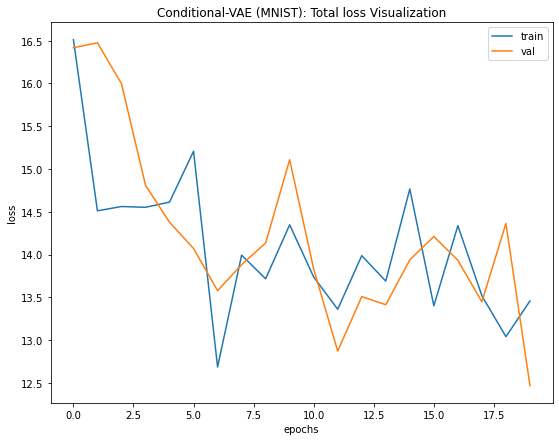

In [50]:
# Visualize total training & testing losses-
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_train_loss'] for e in training_metrics.keys()], label = 'train')
plt.plot([training_metrics[e]['total_test_loss'] for e in training_metrics.keys()], label = 'val')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conditional-VAE (MNIST): Total loss Visualization")
plt.legend(loc = 'best')
plt.show()

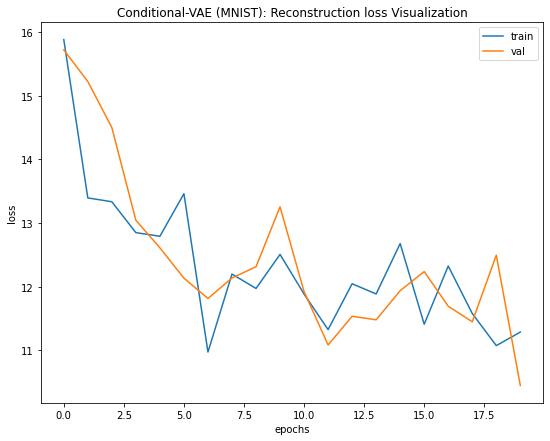

In [51]:
# Visualize training & testing reconstruction losses-
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['train_recon_loss'] for e in training_metrics.keys()], label = 'train')
plt.plot([training_metrics[e]['val_recon_loss'] for e in training_metrics.keys()], label = 'val')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conditional-VAE (MNIST): Reconstruction loss Visualization")
plt.legend(loc = 'best')
plt.show()

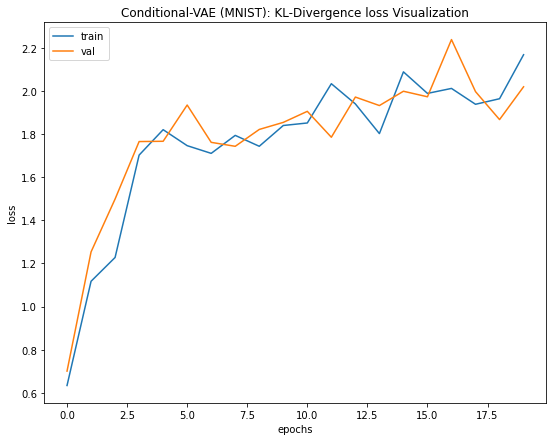

In [52]:
# Visualize training & testing KL-divergence losses-
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['train_kl_loss'] for e in training_metrics.keys()], label = 'train')
plt.plot([training_metrics[e]['val_kl_loss'] for e in training_metrics.keys()], label = 'val')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conditional-VAE (MNIST): KL-Divergence loss Visualization")
plt.legend(loc = 'best')
plt.show()

In [53]:
del model

In [46]:
# Initialize and load 'best' trained parameters-
model_best = VAE(latent_space = 3)

In [47]:
# Get a sample batch of data-
x, y = next(iter(test_dataset))

In [49]:
x_recon, mu, log_var = model_best(x, y)

In [50]:
model_best.load_weights("Conditional_VAE.h5")

In [51]:
del x_recon

In [67]:
def generate_new_data(model, x, y, latent_space = 3, random_noise = 1):
    '''
    Generate synthetic data using supplied parameters.
    
    random_noise = 1: generate 'z' using learned 'mu' & 'log_var' vectors using data.
    random_noise = 2: generate 'z' - z = mu + log_var; no 'eps' is used to add random noise.
    random_noise = 3: sample from a multivariate, standard, Gaussian distribution.
    '''
    if random_noise == 1:
        # Get reconstructions, mean & log-variance-
        x_recon, mu, log_var = model_best(x, y)
        
        return x_recon, mu, log_var, z
    
    elif random_noise == 2:
        # Pass through encoder-
        x = model.encoder(tf.concat(values = [x, y], axis = 1))
        
        # Use mean and log-var vectors to get 'z' latent space-
        mu = model.mu(x)
        log_var = model.log_var(x)
        z = mu + log_var
        
        # Get C-VAE reconstructions-
        x_recon = tf.keras.activations.sigmoid(model.decoder(tf.concat(values = [z, y], axis = 1)))
        
        return x_recon, mu, log_var, z
    
    elif random_noise == 3:
        # Sample from a standard, normal Gaussian distribution-
        z = tf.random.normal(shape = (batch_size, latent_space), mean = 0.0, stddev = 1.0)
        
        # Get reconstructions-
        x_recon = tf.keras.activations.sigmoid(model.decoder(tf.concat(values = [z, y], axis = 1)))
        
        return x_recon, 0, 0, z
        

In [68]:
x_recon, mu, log_var, z = generate_new_data(
    model = model_best, x = x,
    y = y, latent_space = 3,
    random_noise = 3
)

In [ ]:
'''
x_t, y_t = next(iter(test_dataset))

# Get reconstructions, mean & log-variance-
x_recon, mu, log_var = model_best(x_t, y_t)

# Sanity check-
x_recon.shape, x_t.shape
# (TensorShape([256, 784]), TensorShape([256, 784]))
'''

In [ ]:
del x, y

### Visualize _reconstructions_ using trained Conditional-VAE model 

In [69]:
# Reshape reconstructions-
x_recon = tf.reshape(
    tensor = x_recon,
    shape = ((x_recon.shape[0], 28, 28))
)

In [70]:
x_recon.shape

TensorShape([256, 28, 28])

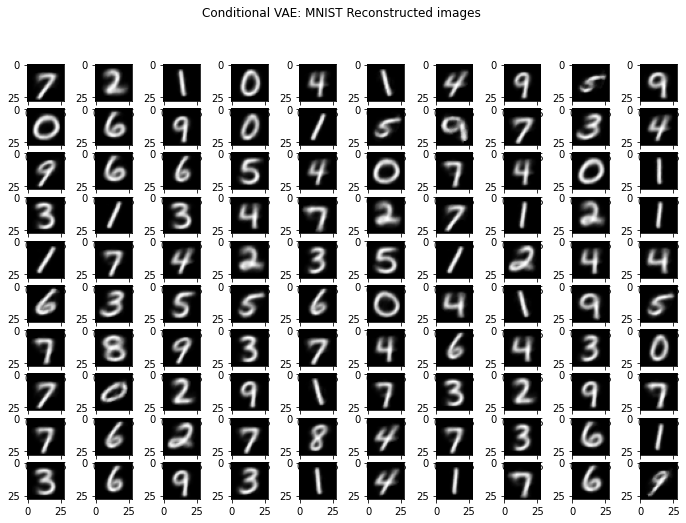

In [71]:
# Visualize 100 reconstruced images-
plt.figure(figsize = (12, 8))
for i in range(100):
    # 10 rows & 10 columns-
    plt.subplot(10, 10, i + 1)
    plt.imshow(x_recon[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("Conditional VAE: MNIST Reconstructed images")
plt.show()

#### Computing ```z``` depends on how synthetic data is genrated

```z``` is modified according to ```random_noise``` parameter in ```generate_new_data(model, x, y, latent_space = 3, random_noise = 1)``` function.

In [ ]:
# Get latent vector 'z'-
# z = model_best.get_latent_vector(x = x, y = y)

In [72]:
z.shape

TensorShape([256, 3])

In [73]:
# Condition reconstructions for MNIST digit '9'-
a = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

y = tf.constant(
    # np.repeat([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], 20, axis = 0),
    # np.repeat([a], 20, axis = 0),
    np.repeat([a], 100, axis = 0),
    dtype = tf.float32
)

In [74]:
z_final = tf.concat(values = [z[:100, :], y], axis = 1)

In [75]:
z_final.shape, y.shape

(TensorShape([100, 13]), TensorShape([100, 10]))

In [76]:
# Get reconstructions using trained decoder-
img_recon = model_best.decoder(z_final)

In [77]:
img_recon.shape

TensorShape([100, 784])

In [78]:
img_recon = img_recon.numpy().reshape(img_recon.shape[0], 28, 28)

In [79]:
img_recon.shape

(100, 28, 28)

#### Manually compare whether the image reconstructions are distinct

In [80]:
img_recon[0, :5, :5]

array([[ -9.147451 ,  -9.993864 ,  -9.426667 ,  -9.850509 ,  -9.290671 ],
       [ -9.122796 ,  -9.542484 ,  -9.510376 ,  -9.433093 ,  -9.571954 ],
       [ -9.23269  ,  -9.724986 ,  -9.9841175,  -9.739974 ,  -9.30051  ],
       [ -9.0733385,  -9.863056 ,  -9.047388 ,  -9.452032 , -10.177844 ],
       [ -9.555787 ,  -9.545781 ,  -9.462387 ,  -9.211449 ,  -9.9781885]],
      dtype=float32)

In [81]:
img_recon[1, :5, :5]

array([[ -9.994358 , -10.250818 , -10.276527 , -10.3531275, -10.627078 ],
       [-10.877933 ,  -9.802748 ,  -9.420665 , -10.19706  ,  -9.708812 ],
       [-10.224078 , -10.063351 , -10.232889 , -10.294054 , -10.008791 ],
       [ -9.439298 , -10.12064  , -10.111726 , -10.330219 ,  -9.96014  ],
       [ -9.70914  , -10.12863  ,  -9.186531 ,  -9.960889 ,  -9.373145 ]],
      dtype=float32)

In [82]:
img_recon[-1, :5, :5]

array([[-15.156142 , -16.138601 , -15.334882 , -16.49096  , -15.26576  ],
       [-13.591292 , -15.357444 , -16.448936 , -14.919303 , -16.104174 ],
       [-15.4250965, -16.113157 , -16.110113 , -15.337721 , -15.185052 ],
       [-14.293193 , -16.330915 , -14.945678 , -15.277072 , -17.52177  ],
       [-14.912347 , -16.468933 , -14.573509 , -16.050043 , -17.05098  ]],
      dtype=float32)

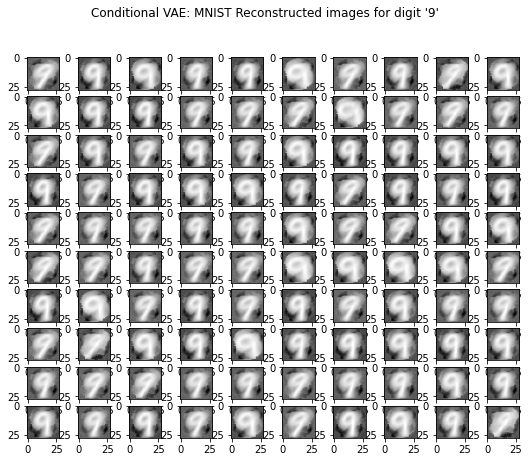

In [83]:
# Visualize 100 reconstruced images for MNIST digit '9'-
plt.figure(figsize = (9, 7))
for i in range(100):
    # 10 rows & 10 columns-
    plt.subplot(10, 10, i + 1)
    plt.imshow(img_recon[i], cmap = plt.get_cmap('gray'))    
    
plt.suptitle("Conditional VAE: MNIST Reconstructed images for digit '9'")
plt.show()

In [90]:
# Condition reconstructions for MNIST digit '5'-
a = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

y = tf.constant(
    np.repeat([a], 100, axis = 0),
    dtype = tf.float32
)

In [91]:
z_final = tf.concat(values = [z[:100, :], y], axis = 1)

In [92]:
# Get reconstructions using trained decoder-
img_recon = model_best.decoder(z_final)

In [93]:
img_recon.shape

TensorShape([100, 784])

In [94]:
img_recon = img_recon.numpy().reshape(img_recon.shape[0], 28, 28)

In [95]:
img_recon.shape

(100, 28, 28)

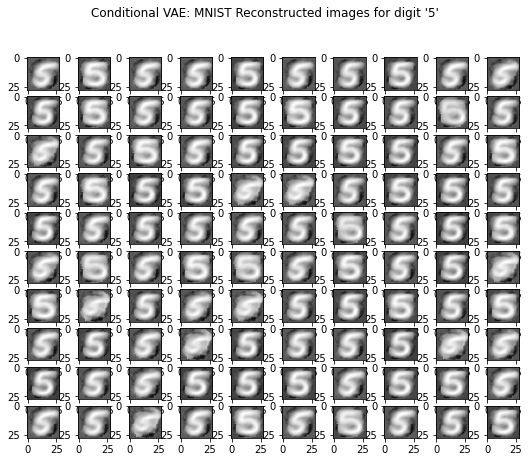

In [96]:
# Visualize 100 reconstruced images for MNIST digit '9'-
plt.figure(figsize = (9, 7))
for i in range(100):
    # 10 rows & 10 columns-
    plt.subplot(10, 10, i + 1)
    plt.imshow(img_recon[i], cmap = plt.get_cmap('gray'))    
    
plt.suptitle("Conditional VAE: MNIST Reconstructed images for digit '5'")
plt.show()

In [97]:
# Condition reconstructions for MNIST digit '3'-
a = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

y = tf.constant(
    np.repeat([a], 100, axis = 0),
    dtype = tf.float32
)

In [98]:
z_final = tf.concat(values = [z[:100, :], y], axis = 1)

In [99]:
# Get reconstructions using trained decoder-
img_recon = model_best.decoder(z_final)

In [100]:
img_recon.shape

TensorShape([100, 784])

In [101]:
img_recon = img_recon.numpy().reshape(img_recon.shape[0], 28, 28)

In [102]:
img_recon.shape

(100, 28, 28)

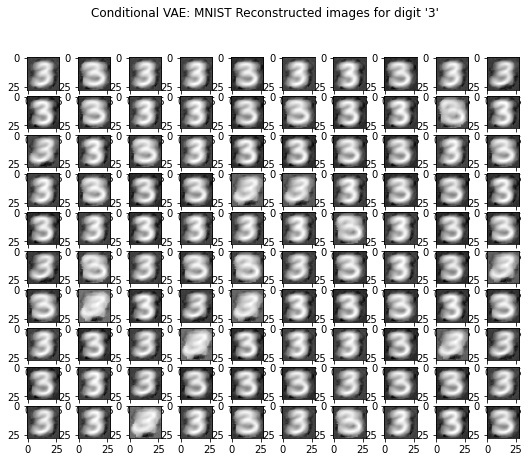

In [103]:
# Visualize 100 reconstruced images for MNIST digit '3'-
plt.figure(figsize = (9, 7))
for i in range(100):
    # 10 rows & 5 columns-
    plt.subplot(10, 10, i + 1)
    plt.imshow(img_recon[i], cmap = plt.get_cmap('gray'))    
    
plt.suptitle("Conditional VAE: MNIST Reconstructed images for digit '3'")
plt.show()

### Visualize learned _latent space_

In [120]:
X_train_concat = tf.concat(values = [X_train, y_train], axis = 1)
X_test_concat = tf.concat(values = [X_test, y_test], axis = 1)

In [121]:
print("\nDimensions of training and testing concatenated sets are:")
print(f"X_train_concat.shape: {X_train_concat.shape} & X_test_concat.shape: {X_test_concat.shape}")


Dimensions of training and testing concatenated sets are:
X_train_concat.shape: (60000, 794) & X_test_concat.shape: (10000, 794)


In [ ]:
# del X_train_concat, X_test_concat

In [122]:
X_train_encoded = model_best.encoder(X_train_concat).numpy()
X_test_encoded = model_best.encoder(X_test_concat).numpy()

In [123]:
# Sanity check-
X_train_encoded.shape, X_test_encoded.shape

((60000, 3), (10000, 3))

In [124]:
del X_train_concat, X_test_concat

In [125]:
print(f"MNIST training encoded statistics:")
for i in range(3):
    print(f"lv: {i + 1}; mean = {X_train_encoded[:, i].mean():.5f}"
          f" & std-dev = {X_train_encoded[:, i].std():.5f}")

MNIST training encoded statistics:
lv: 1; mean = 0.00000 & std-dev = 0.00000
lv: 2; mean = 1.60462 & std-dev = 0.80855
lv: 3; mean = 2.86365 & std-dev = 0.55018


In [126]:
print(f"MNIST testing encoded statistics:")
for i in range(3):
    print(f"lv: {i + 1}; mean = {X_test_encoded[:, i].mean():.5f}"
          f" & std-dev = {X_test_encoded[:, i].std():.5f}")

MNIST testing encoded statistics:
lv: 1; mean = 0.00000 & std-dev = 0.00000
lv: 2; mean = 1.58185 & std-dev = 0.77929
lv: 3; mean = 2.87481 & std-dev = 0.54179


### Observation

It seems that the first _latent variable_ is not used at all. And this is evident from the visualizations below which show the encoded data points being embedded in a 2-D plane within the 3-D latent space.

In [ ]:
# Visualize encoded testing images in latent space-
fig = px.scatter_3d(
    x = X_test_encoded[:, 0], y = X_test_encoded[:, 1],
    z = X_test_encoded[:, 2],
    color = np.argmax(y_test, axis = 1),
    title = "Encoded MNIST testing images"
)
fig.show()

In [ ]:
# Visualize encoded training images in latent space-
fig = px.scatter_3d(
    x = X_train_encoded[:, 0], y = X_train_encoded[:, 1],
    z = X_train_encoded[:, 2],
    color = np.argmax(y_train, axis = 1),
    title = "Encoded MNIST training images"
)
fig.show()

In [127]:
# Delete datasets; for large datasets (CIFAR-10, etc.), you might get
# OOM error from GPU depending on your specifications.
del X_train_encoded, X_test_encoded

In [104]:
mu.shape, log_var.shape

(TensorShape([256, 3]), TensorShape([256, 3]))

In [105]:
print(f"mu: mean = {mu.numpy().mean():.4f} & "
f"std dev = {mu.numpy().std():.4f}")

mu: mean = 0.1005 & std dev = 0.5328


In [106]:
print(f"log var: mean = {log_var.numpy().mean():4f} &"
f" std dev = {log_var.numpy().std():.4f}")

log var: mean = -1.374159 & std dev = 1.9543


In [128]:
mu = mu.numpy()
log_var = log_var.numpy()

In [129]:
mu.shape, log_var.shape

((256, 3), (256, 3))

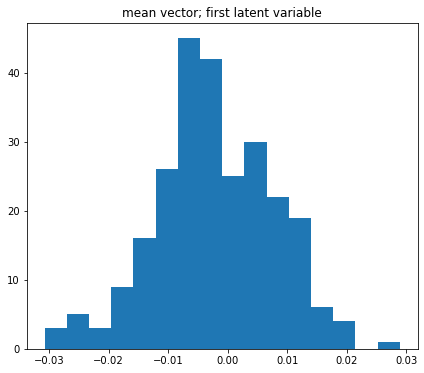

In [131]:
plt.figure(figsize = (7, 6))
plt.hist(mu[:, 0], bins = int(np.ceil(np.sqrt(len(mu)))))
plt.title("mean vector; first latent variable")
plt.show()

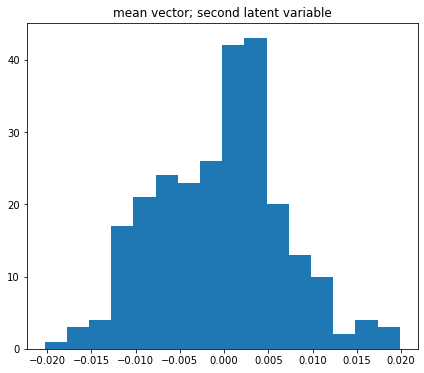

In [132]:
plt.figure(figsize = (7, 6))
plt.hist(mu[:, 1], bins = int(np.ceil(np.sqrt(len(mu)))))
plt.title("mean vector; second latent variable")
plt.show()

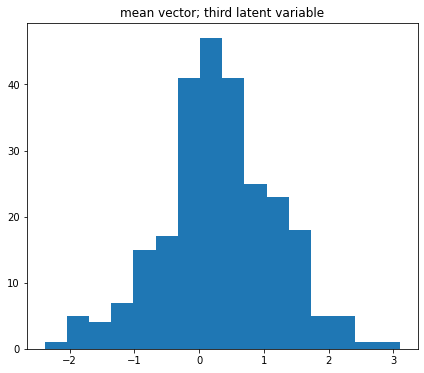

In [133]:
plt.figure(figsize = (7, 6))
plt.hist(mu[:, 2], bins = int(np.ceil(np.sqrt(len(mu)))))
plt.title("mean vector; third latent variable")
plt.show()

In [ ]:
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    color = np.argmax(y_t, axis = 1),
    title = "Latent space: mean vector"
    )
fig.show()

In [ ]:
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    color = np.argmax(y_t, axis = 1),
    title = "Latent space: log-var vector"
    )
fig.show()